### Download data from AWS RDS to DataFrame

In [331]:
# import dependencies

import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

import plotly.express as px
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
# Database engine to connect with AWS RDS

dialect = 'postgresql'
username = 'postgres'
password = 'bootcamp2021'
host = 'bootcamp-final-cln.ch1wrcuq3max.us-east-2.rds.amazonaws.com'
database = 'crime'
engine = create_engine(f'{dialect}://{username}:{password}@{host}/{database}')

In [3]:
# upload additional tables

property_type_df_file = os.path.join('data_prep', 'property_type_df.csv')
pd.read_csv(property_type_df_file).to_sql(name='property_type_crime', con=engine, if_exists='replace')

violent_type_df_file = os.path.join('data_prep', 'violent_type_df.csv')
pd.read_csv(violent_type_df_file).to_sql(name='violent_type_crime', con=engine, if_exists='replace')

In [4]:
# list all the tables on the AWS RDS

inspector = inspect(engine)
inspector.get_table_names()

['offense_cat_offender_race_2020',
 'offense_cat_offender_sex_2020',
 'offense_cat_type_2020',
 'offense_cat_victim_age_2020',
 'offense_cat_victim_race_2020',
 'offense_cat_victim_sex_2020',
 'state_pop_agencies_2020',
 'gpd_by_state_2020',
 'state_size',
 'property_type_crime',
 'violent_type_crime',
 'offense_cat_loc_2020',
 'offense_cat_state_2020',
 'law_enforcement_state_2020',
 'law_enforcement_state_city_2020',
 'offense_cat_offender_age_2020']

In [31]:
with engine.connect() as conn:
    property_crime_df = pd.read_sql("SELECT * FROM violent_type_crime", conn)
    violent_crime_df = pd.read_sql("SELECT * FROM property_type_crime", conn)

property_crime_df.drop(['index'], axis=1, inplace=True)
property_crime_df.set_index('FIPS', inplace=True)

violent_crime_df.drop('index', axis=1, inplace=True)
violent_crime_df.set_index('FIPS', inplace=True)

print(property_crime_df.shape)
print(violent_crime_df.shape)

(2000, 15)
(2071, 15)


In [32]:
violent_crime_df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,,
1001.0,384.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1003.0,737.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
1007.0,69.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
1015.0,211.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
1033.0,267.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


In [33]:
property_crime_df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,,
1001.0,55.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1003.0,163.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
1007.0,3.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
1015.0,18.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
1033.0,58.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


### Analyse property crimes

#### normalize columns against population

In [41]:
df = property_crime_df

In [42]:
# normalize columns against population

columns_to_normalize = [
    'crimes',
    'total_law_emp',
    'officers',
    'civilians'    
]

for col in columns_to_normalize:
    df[col] = df[col] / df['population']

df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,,
1001.0,3.269983e-13,4.102342e-13,1.843081e-13,2.259261e-13,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1003.0,1.808538e-14,3.284215e-14,1.231581e-14,2.052635e-14,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
1007.0,2.624286e-13,8.747620e-13,7.872858e-13,8.747620e-14,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
1015.0,1.180509e-14,3.672694e-14,3.344775e-14,3.279191e-15,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
1033.0,3.583918e-13,3.274959e-13,2.100917e-13,1.174042e-13,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


#### Scale the input dataset

In [209]:
y = df['crimes']
X = df.drop('crimes', axis=1)

# y = np.asarray(y).reshape(-1, 1)

# Create scaler instance
X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit the scaler
X_scaler.fit(X)
y_scaler.fit(np.asarray(y).reshape(-1, 1))

# Scale the data
scaled_X = X_scaler.transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns, index=X.index)
scaled_y = y_scaler.transform(np.asarray(y).reshape(-1, 1))
scaled_y = pd.DataFrame(scaled_y, columns=['crimes'], index=X.index)

scaled_X.head()

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,
1001.0,-0.023194,-0.023240,-0.023102,-0.193848,-0.055545,-0.519864,0.435229,-0.307508,0.109019,-0.155022,-0.160438,-0.359997,-0.421222,-0.471226
1003.0,-0.023197,-0.023242,-0.023107,-0.578749,-0.885522,0.056424,0.984712,-0.179593,0.218714,0.244481,-0.096669,-0.729688,-0.721456,-0.613078
1007.0,-0.023190,-0.023233,-0.023106,1.396355,1.524983,-1.416818,-1.246495,0.012280,-0.581767,-0.240388,-0.255433,1.155739,0.829752,0.921503
1015.0,-0.023197,-0.023242,-0.023108,0.492708,-0.167234,0.425899,-0.405008,0.396026,-0.593219,0.001474,0.002349,0.582717,0.667126,0.612008
1033.0,-0.023195,-0.023240,-0.023105,0.371077,0.538878,-0.358900,-0.439673,0.587899,-0.664474,-0.156864,-0.161986,0.102118,0.016619,0.070391


#### Try linear regression

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.806073027241837, tolerance: 0.13387109593687188

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.824933416359045, tolerance: 0.13387109593687188

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality

Coefficients: 
 [ 0.          0.00736314  0.         -0.0809331  -0.01091825  0.
  0.07492143 -0.02565037  0.         -0.01490562 -0.04101373 -0.15628137
  0.12101549  0.17664001]
Intercept: 
 -3.650380550091695e-17
Mean squared error: 0.98
Coefficient of determination (Rsqured): 0.02


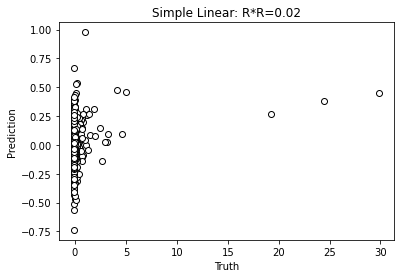

In [212]:
from sklearn.linear_model import ElasticNetCV

regr = ElasticNetCV(cv=5, random_state=0)

regr.fit(scaled_X, scaled_y)

y_pred = regr.predict(scaled_X)

# # The alpha hyperparameter
# print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)
print("Intercept: \n", regr.intercept_)
print("Mean squared error: %.2f" % mean_squared_error(scaled_y, y_pred))
print("Coefficient of determination (Rsqured): %.2f" % r2_score(scaled_y, y_pred))

# Plot outputs
plt.scatter(scaled_y, y_pred, edgecolors="black", marker='o', color='white')

plt.title(f"Simple Linear: R*R=%.2f" % r2_score(scaled_y, y_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30374684105527194, tolerance: 0.13387109593687188

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6150984217024416, tolerance: 0.13387109593687188

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Dual

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26409765662083373, tolerance: 0.19900360019578545

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5686464498376154, tolerance: 0.19900360019578545

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0709223115015902, tolerance: 0.19900360019578545

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteratio

Coefficients: 
 [ 0.          0.00736314  0.         -0.0809331  -0.01091825  0.
  0.07492143 -0.02565037  0.         -0.01490562 -0.04101373 -0.15628137
  0.12101549  0.17664001]
Intercept: 
 -3.650380550091695e-17
Mean squared error: 0.98
Coefficient of determination (Rsqured): 0.02


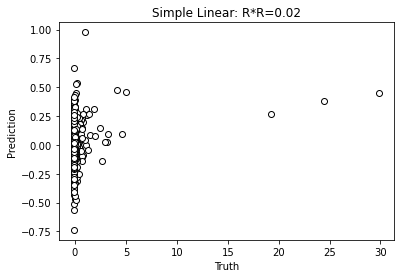

In [221]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor

regr = ElasticNetCV(cv=5, random_state=0, max_iter=10000)
# regr = LassoCV(cv=5, random_state=0, max_iter=10000)
# regr = LinearRegression()
# regr = TweedieRegressor(power=2, alpha=0.5, link='log')

regr.fit(scaled_X, scaled_y)

y_pred = regr.predict(scaled_X)

# # The alpha hyperparameter
# print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)
print("Intercept: \n", regr.intercept_)
print("Mean squared error: %.2f" % mean_squared_error(scaled_y, y_pred))
print("Coefficient of determination (Rsqured): %.2f" % r2_score(scaled_y, y_pred))

# Plot outputs
plt.scatter(scaled_y, y_pred, edgecolors="black", marker='o', color='white')

plt.title(f"Simple Linear: R*R=%.2f" % r2_score(scaled_y, y_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

#### Linear regression does not achieve good performance
#### Try unsupervised machine learning to identify clusters

In [224]:
scaled_df = scaled_X.merge(scaled_y, how='inner', left_on='FIPS', right_on='FIPS')
scaled_df

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,crimes
FIPS,,,,,,,,,,,,,,,
1001.0,-0.023194,-0.023240,-0.023102,-0.193848,-0.055545,-0.519864,0.435229,-0.307508,0.109019,-0.155022,-0.160438,-0.359997,-0.421222,-0.471226,-0.084972
1003.0,-0.023197,-0.023242,-0.023107,-0.578749,-0.885522,0.056424,0.984712,-0.179593,0.218714,0.244481,-0.096669,-0.729688,-0.721456,-0.613078,-0.085848
1007.0,-0.023190,-0.023233,-0.023106,1.396355,1.524983,-1.416818,-1.246495,0.012280,-0.581767,-0.240388,-0.255433,1.155739,0.829752,0.921503,-0.085155
1015.0,-0.023197,-0.023242,-0.023108,0.492708,-0.167234,0.425899,-0.405008,0.396026,-0.593219,0.001474,0.002349,0.582717,0.667126,0.612008,-0.085866
1033.0,-0.023195,-0.023240,-0.023105,0.371077,0.538878,-0.358900,-0.439673,0.587899,-0.664474,-0.156864,-0.161986,0.102118,0.016619,0.070391,-0.084883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56035.0,-0.022627,-0.022820,-0.022241,-1.450215,0.091062,1.491123,0.041666,0.076238,1.436479,-0.273246,-0.312684,-1.265741,-1.384472,-1.373921,-0.057117
56037.0,-0.023189,-0.023237,-0.023092,-0.911691,-0.132145,1.230236,0.012210,0.140195,1.609527,-0.183979,-0.309005,-1.062411,-1.146787,-1.270756,-0.085140
56041.0,-0.023155,-0.023196,-0.023073,-0.904092,1.055165,0.825266,-0.659666,0.140195,0.947672,-0.245399,-0.299502,-1.025442,-1.209336,-1.322339,-0.085252


In [225]:
inertia = []
k = list(range(1, 11))

# Looking for the best K
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(scaled_df)
    inertia.append(km.inertia_)
    
# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

In [234]:
n_cluster = 6

In [287]:
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_.astype(str)

    return data

In [288]:
clusters_df = get_clusters(n_cluster, scaled_df)
clusters_df.head()

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,crimes,class
FIPS,,,,,,,,,,,,,,,,
1001.0,-0.023194,-0.023240,-0.023102,-0.193848,-0.055545,-0.519864,0.435229,-0.307508,0.109019,-0.155022,-0.160438,-0.359997,-0.421222,-0.471226,-0.084972,0
1003.0,-0.023197,-0.023242,-0.023107,-0.578749,-0.885522,0.056424,0.984712,-0.179593,0.218714,0.244481,-0.096669,-0.729688,-0.721456,-0.613078,-0.085848,0
1007.0,-0.023190,-0.023233,-0.023106,1.396355,1.524983,-1.416818,-1.246495,0.012280,-0.581767,-0.240388,-0.255433,1.155739,0.829752,0.921503,-0.085155,2
1015.0,-0.023197,-0.023242,-0.023108,0.492708,-0.167234,0.425899,-0.405008,0.396026,-0.593219,0.001474,0.002349,0.582717,0.667126,0.612008,-0.085866,1
1033.0,-0.023195,-0.023240,-0.023105,0.371077,0.538878,-0.358900,-0.439673,0.587899,-0.664474,-0.156864,-0.161986,0.102118,0.016619,0.070391,-0.084883,1


In [289]:
clusters_df.groupby(by='class').count()

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,crimes
class,,,,,,,,,,,,,,,
0,804,804,804,804,804,804,804,804,804,804,804,804,804,804,804
1,805,805,805,805,805,805,805,805,805,805,805,805,805,805,805
2,335,335,335,335,335,335,335,335,335,335,335,335,335,335,335
3,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [291]:
# Plotting the clusters with three features
fig = px.scatter_3d(clusters_df, 
                    x="total_law_emp", 
                    range_x=[min(clusters_df['total_law_emp']), max(clusters_df['total_law_emp'])/250],
                    y="median_HH_Income", 
                    z="crimes", 
                    color="class", 
                    symbol="class", 
#                     size="crime_to_pop_ratio",
                    width=800)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

In [296]:
cluster_no = 2

Coefficient of determination (Rsqured): 0.81
Coefficients: 
 [ 0.00000000e+00  8.26600694e+01  0.00000000e+00  1.00687235e-02
 -7.34338376e-04  5.12579866e-03 -0.00000000e+00 -2.46917355e-03
 -2.64262787e-02 -1.19799373e-02 -3.77042043e-02 -2.00975029e-02
 -5.02227782e-02  7.38709585e-02]
Intercept: 
 1.8037559660833744
Mean squared error: 0.01
Coefficient of determination (Rsqured): 0.81


C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



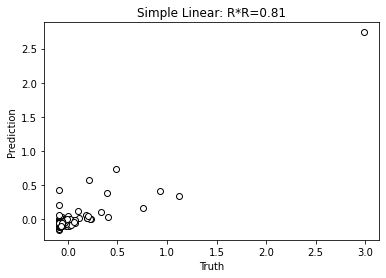

In [295]:
cluster_subset_df = clusters_df[clusters_df['class']==str(cluster_no)]
cluster_subset_df.drop('class', axis=1, inplace=True)


subset_y = cluster_subset_df['crimes']
subset_X = cluster_subset_df.drop('crimes', axis=1)

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor

# regr = ElasticNetCV(cv=5, random_state=0)
# regr.fit(subset_X, subset_y)
# y_pred = regr.predict(subset_X)
# print("Coefficient of determination (Rsqured): %.2f" % r2_score(subset_y, y_pred))

regr = LassoCV(cv=5, random_state=0)
regr.fit(subset_X, subset_y)
y_pred = regr.predict(subset_X)
print("Coefficient of determination (Rsqured): %.2f" % r2_score(subset_y, y_pred))

# regr = LinearRegression()
# regr.fit(subset_X, subset_y)
# y_pred = regr.predict(subset_X)
# print("Coefficient of determination (Rsqured): %.2f" % r2_score(subset_y, y_pred))

# regr = TweedieRegressor(power=0, alpha=0.5, link='log')



# # The alpha hyperparameter
# print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)
print("Intercept: \n", regr.intercept_)
print("Mean squared error: %.2f" % mean_squared_error(subset_y, y_pred))
print("Coefficient of determination (Rsqured): %.2f" % r2_score(subset_y, y_pred))

# Plot outputs
plt.scatter(subset_y, y_pred, edgecolors="black", marker='o', color='white')

plt.title(f"Simple Linear: R*R=%.2f" % r2_score(subset_y, y_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")
# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(min(subset_y), max(subset_y)/6)
# plt.ylim(min(subset_y), max(subset_y)/6)

plt.show()


R_squared:

subset   ENCV   LassoCV   LR

0        0.25   0.09      0.30

1        0      0         0.07

2        0.42   0.81      0.83

3        0.04   0.04      0.91

### Examine the distribution of "Crimes" data

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

invalid value encountered in log10



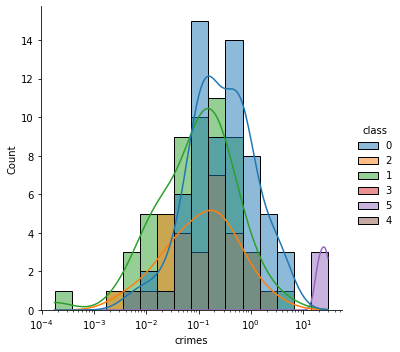

In [311]:
sns.displot(clusters_df.reset_index(), 
            x="crimes",
#             kind='kde',
#             cut=0,
            hue='class',
            log_scale=True,
            kde=True, 
            )

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



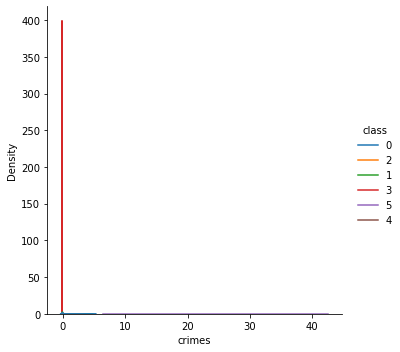

In [320]:
sns.displot(clusters_df.reset_index(), 
            x="crimes",
            kind='kde',
#             cut=0,
            hue='class',
#             kde=True, 
            )

### Try NN model

In [ ]:
cluster_no = 0

In [321]:
cluster_subset_df = clusters_df[clusters_df['class']==str(cluster_no)]
cluster_subset_df.drop('class', axis=1, inplace=True)


nn_y = cluster_subset_df['crimes']
nn_X = cluster_subset_df.drop('crimes', axis=1)

X_train, X_test, y_train, y_test = train_test_split(nn_X, nn_y, random_state=78)

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 10)                150       
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
None


Text(0, 0.5, 'Predicted')

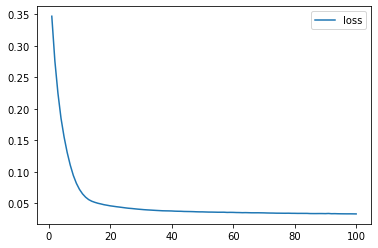

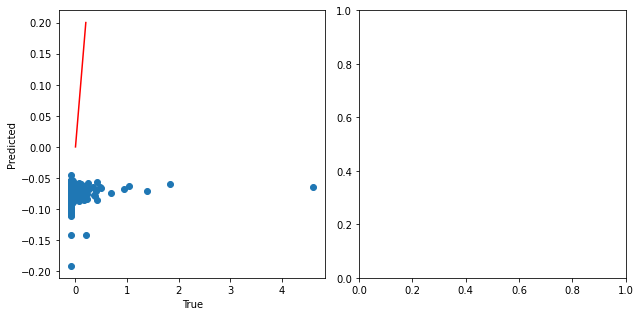

In [356]:
units_input = 10
units_h1 = 0
units_h2 = 0
units_h3 = 0
activation_input = 'relu'
activation_h1 = 'relu'
activation_h2 = 'relu'
activation_h3 = 'relu'
activation_output = 'LeakyReLU'
epochs = 100


# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=units_input, activation=activation_input, input_dim=nn_X.shape[1]))
if units_h1 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h1, activation=activation_h1))
if units_h2 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h2, activation=activation_h2))
if units_h3 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h3, activation=activation_h3))
nn_model.add(tf.keras.layers.Dense(units=1, activation=activation_output))

# Check the structure of the Sequential model
print(nn_model.summary())

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="mean_absolute_error", 
                 optimizer=tf.optimizers.Adam(learning_rate=0.001), 
#                  metrics=["MeanSquaredError"]
                )

# Fit the model to the training data
fit_model = nn_model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

# compare results
result = pd.DataFrame()
result['True'] = nn_y
result['Predicted'] = nn_model.predict(nn_X)
result.head()

# compare Predicted with True
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
ax1.scatter(result['True'],result['Predicted'])
ax1.plot([0, 0.2], [0, 0.2], 'r')
ax1.set_xlabel('True')
ax1.set_ylabel('Predicted')
# ax2.scatter(result['True'], result['Predicted'])
# ax2.plot([0, 0.2], [0, 0.2], 'r')
# ax2.set_xlim(0, 0.25)
# ax2.set_ylim(0, 0.25)
# ax2.set_xlabel('True')
# ax2.set_title('Zoom into Diagnol')

In [366]:
df.sort_values(by='crimes', ascending=False)

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,,
30037.0,1.054009e-08,5.270045e-09,5.270045e-09,0.000000e+00,8.034188,40.683762,28.547009,22.735043,5.1,40469.0,724,0.238022,19.7,32.9,33.0
6003.0,8.637529e-09,1.129523e-08,7.973103e-09,3.322126e-09,8.831169,28.051949,28.571428,34.545456,6.2,58112.0,1146,0.599281,17.2,29.6,25.5
48033.0,6.800879e-09,1.020132e-08,6.800879e-09,3.400440e-09,5.263158,20.095694,35.167465,39.473682,3.7,71926.0,665,0.286100,10.6,15.4,15.4
8079.0,1.793909e-09,1.255737e-08,7.175637e-09,5.381728e-09,2.582496,15.781922,35.150646,46.484936,1.7,63015.0,823,0.362841,9.4,16.0,16.2
30079.0,1.655017e-09,1.655017e-09,1.241263e-09,4.137542e-10,12.039045,30.694143,35.032539,22.234274,3.7,46663.0,1342,0.298369,13.1,19.1,19.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20145.0,0.000000e+00,5.298423e-11,2.980363e-11,2.318060e-11,9.382566,33.091202,37.974174,19.552057,3.3,65141.0,6709,3.434293,14.0,18.1,16.6
21237.0,0.000000e+00,1.326836e-11,5.307343e-12,7.961014e-12,28.218014,37.437187,25.686123,8.658678,8.9,32773.0,7223,12.552590,30.1,44.0,42.7
27069.0,0.000000e+00,1.348418e-10,6.129171e-11,7.355005e-11,5.459864,36.204094,32.466690,25.869352,3.7,62762.0,4337,1.523938,9.2,11.5,10.8


C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



ValueError: autodetected range of [-inf, -7.977155707263479] is not finite

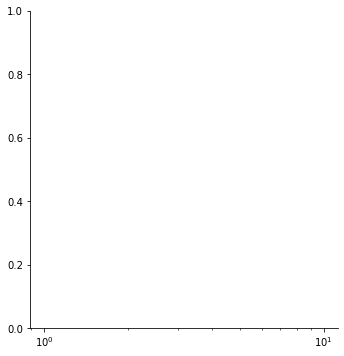

In [364]:
sns.displot(df.reset_index(), 
            x="crimes",
#             kind='kde',
#             cut=0,
#             hue='class',
            log_scale=True,
            kde=True, 
            )